In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")
import logging

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from xlstm_scaling_laws.analysis.estimate_optimal_flop_param_token_tables import (
    add_token_param_ratio_plot_type,
    create_scaling_law_parameters_dataframe,
    estimate_optimal_flops_tokens_table,
    format_estimated_table_with_fit_params,
    format_token_param_ratio_for_display,
)
from xlstm_scaling_laws.analysis.isoflop.plot.isocurve_ctx import (
    get_isoflop_powerlaw_ctx_plot,
)
from xlstm_scaling_laws.analysis.isoflop.plot.isocurve_powerlaw import (
    get_isoflop_powerlaw_plot,
)

logging.basicConfig(
    level=logging.ERROR,
    format="%(levelname)s: %(message)s",
    force=True,
)


def add_row_colors(latex_str):
    lines = latex_str.split("\n")
    new_lines = []
    in_tabular = False
    row_count = 0

    for line in lines:
        if "\\begin{tabular}" in line:
            in_tabular = True
            new_lines.append(line)
        elif "\\end{tabular}" in line:
            in_tabular = False
            new_lines.append(line)
        elif in_tabular and "\\\\" in line and not line.strip().startswith("\\"):
            if row_count % 2 == 1:
                new_lines.append("\\rowcolor{gray!10}" + line)
            else:
                new_lines.append(line)
            row_count += 1
        else:
            new_lines.append(line)

    return "\n".join(new_lines)


def add_adjustbox_scaling(latex_str, height_scale=0.9):
    """Add adjustbox scaling to a LaTeX table"""
    lines = latex_str.split("\n")
    new_lines = []

    for i, line in enumerate(lines):
        if "\\begin{tabular}" in line:
            new_lines.append(
                f"\\begin{{adjustbox}}{{max height={height_scale}\\textheight,center}}"
            )
            new_lines.append(line)
        elif "\\end{tabular}" in line:
            new_lines.append(line)
            new_lines.append("\\end{adjustbox}")
        else:
            new_lines.append(line)

    return "\n".join(new_lines)

# Estimated optimal training FLOPs and training tokens for various model sizes


In this notebook, we want to create estimates for the optimal training FLOPs and training tokens for various model sizes based on our scaling law. 

Specifically, we will create tables similar to Table 3 and Table A3 in the Chinchilla paper [1].

The chinchilla paper uses three different approaches to compute scaling laws and show the optimal training FLOP and token estimates for each individually. 
The xLSTM scaling law study reproduces their approaches:
- Power law fits to overtraining: Similar to Approach 1 (we do not smooth and then interpolate the training loss curve to determines the optima)
- IsoFLOP curves: Approach 2
- LND-fit: Approach 3

We will primarily use Approach 2 for our estimates. 
We cannot use Approach 3, since we do not use the C = 6ND approximation and therefore we would need to numerically minimize our parametric loss fits for a specific flop constraint.


[1] Hoffmann, Jordan, Sebastian Borgeaud, Arthur Mensch, et al. “Training Compute-Optimal Large Language Models.” arXiv:2203.15556. Preprint, arXiv, March 29, 2022. https://doi.org/10.48550/arXiv.2203.15556.




Our estimates will be primarily based on the laws fitted in these plots:

/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)


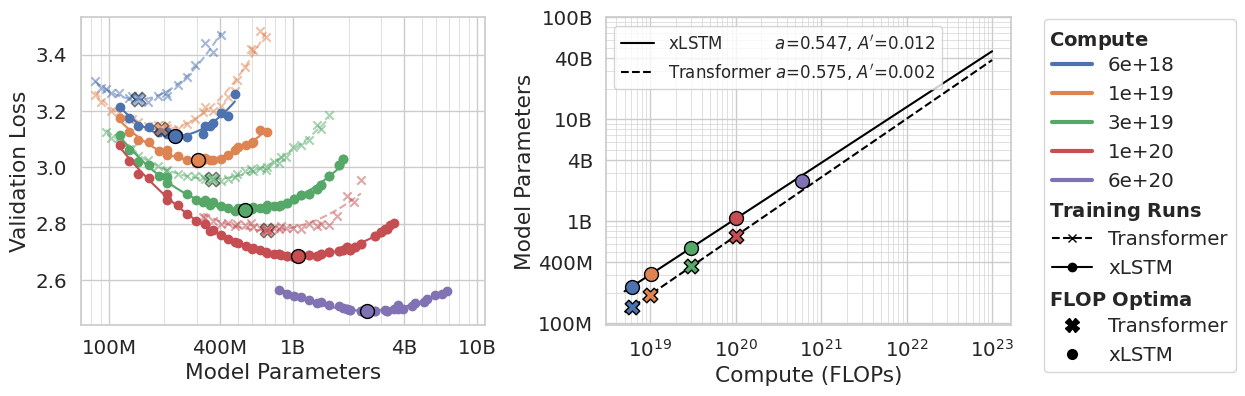

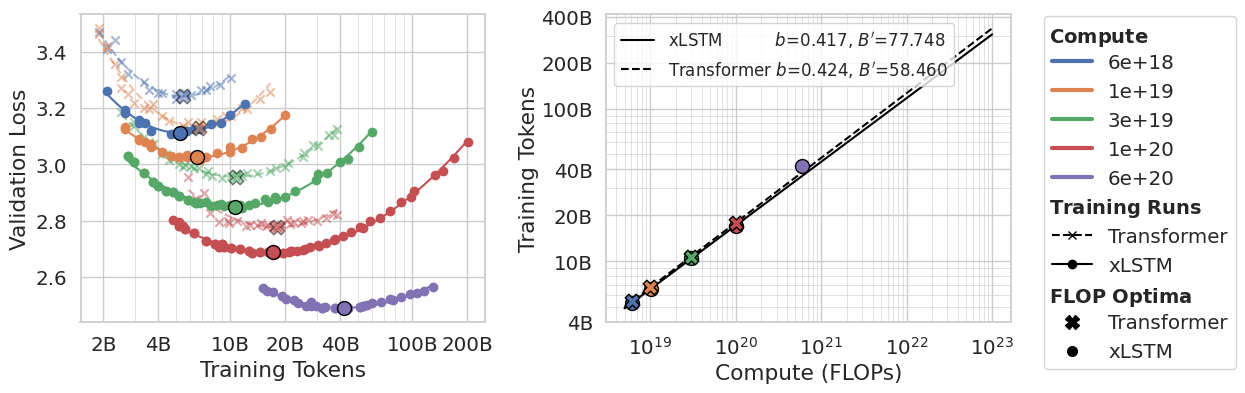

In [2]:
with sns.plotting_context("notebook", font_scale=1.3):
    with sns.axes_style("whitegrid"):
        fig = get_isoflop_powerlaw_plot(
            plot_type="num_params",
            fit_in_log_space=True,
            figsize=(12, 4),
            legend_kwargs={
                "loc": "upper left",
                "ncol": 1,
                "bbox_to_anchor": (0.92, 0.9),
                "frameon": True,
                "facecolor": "white",
                # "alignment": "top",
                # "labelspacing": 1.1,
            },
            gridspec_kw={"wspace": 0.3},
        )
with sns.plotting_context("notebook", font_scale=1.3):
    with sns.axes_style("whitegrid"):
        fig = get_isoflop_powerlaw_plot(
            plot_type="num_tokens_training",
            fit_in_log_space=True,
            figsize=(12, 4),
            legend_kwargs={
                "loc": "upper left",
                "ncol": 1,
                "bbox_to_anchor": (0.92, 0.9),
                "frameon": True,
                "facecolor": "white",
                # "alignment": "top",
                # "labelspacing": 1.1,
            },
            gridspec_kw={"wspace": 0.3},
        )

/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alp

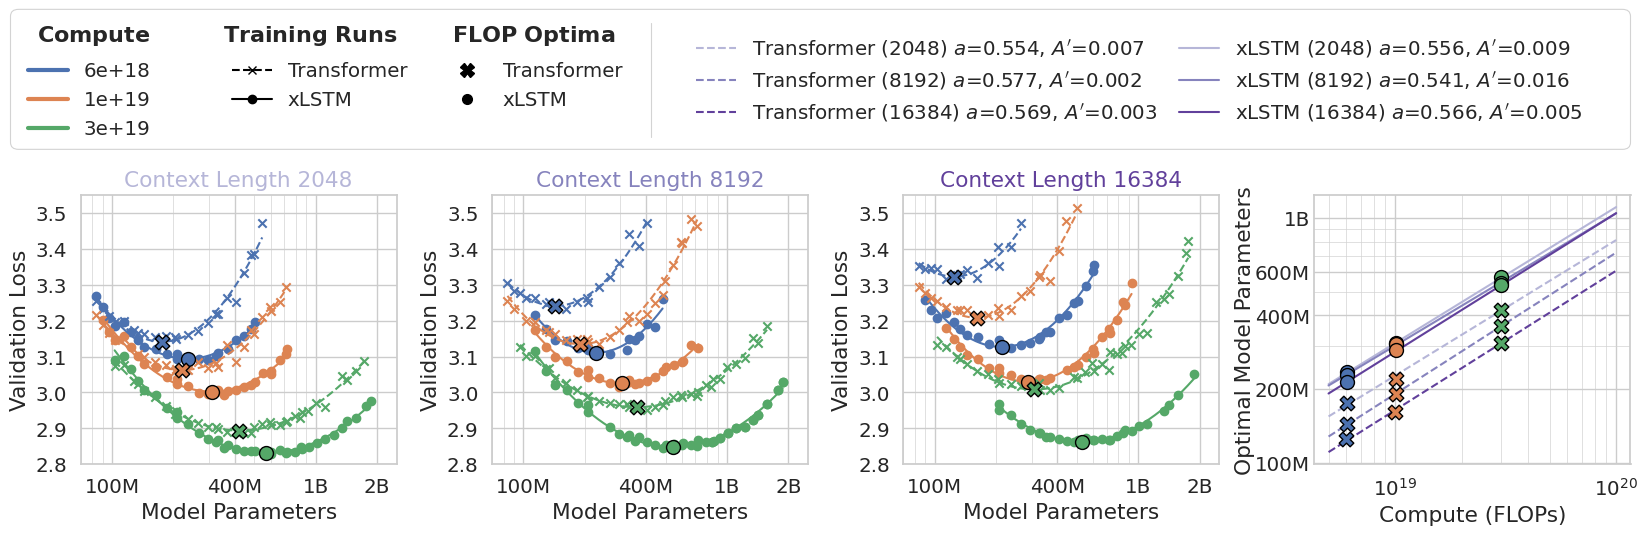

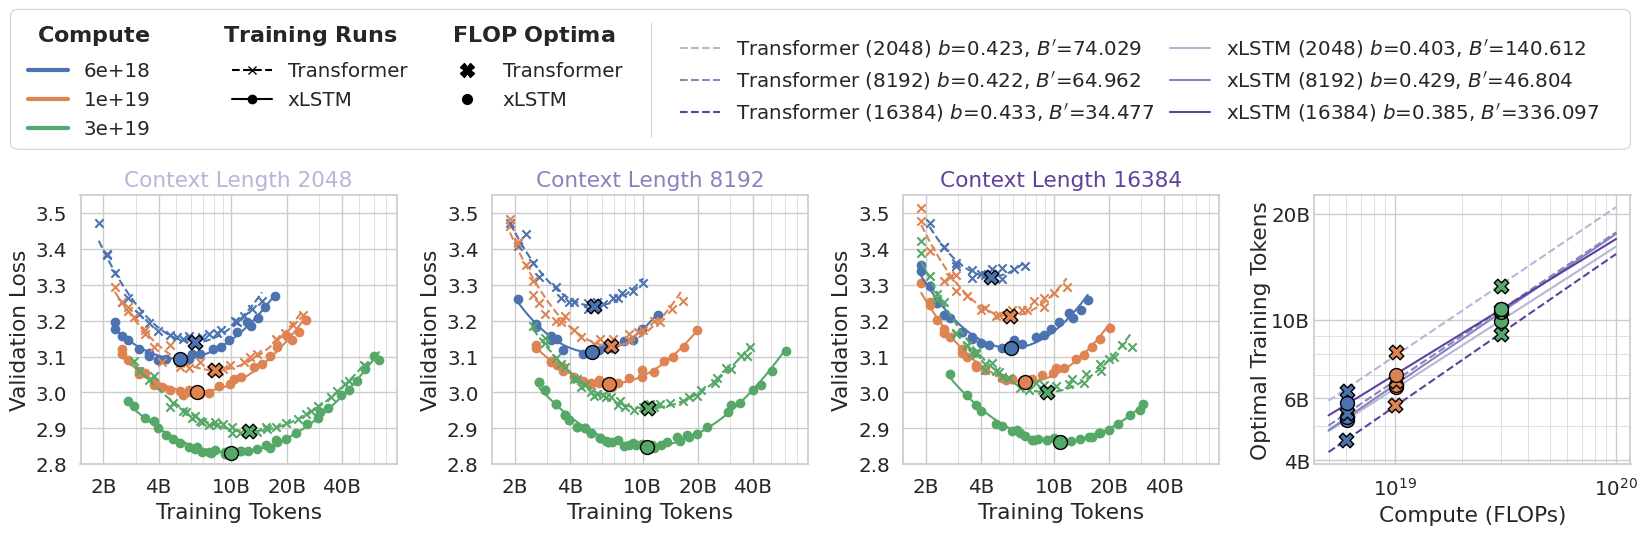

In [3]:
legend_offset = 0.15
frameon = False
with sns.plotting_context("notebook", font_scale=1.3):
    with sns.axes_style(
        "whitegrid",
        rc={
            # "xtick.bottom": True,
            # "ytick.left": True,
            # "xtick.color": "lightgrey",
            # "ytick.color": "lightgrey",
        },
    ):
        fig = get_isoflop_powerlaw_ctx_plot(
            x_col="num_params",
            y_col="val/.dclm_loss",
            figsize=(20, 3.5),
            legend_kwargs={
                "ncols": 3,
                "loc": "lower left",
                "bbox_to_anchor": (0.09, 0.84 + legend_offset),
                "facecolor": "white",
                "frameon": frameon,
            },
            legend_kwargs_powerlaw_plot={
                "ncols": 2,
                "columnspacing": 1.1,
                "loc": "lower left",
                "bbox_to_anchor": (
                    -2.01,
                    1.05 + legend_offset,
                ),  # Adjust the vertical position as needed
                "frameon": frameon,
            },
            gridspec_kw={"wspace": 0.3},
            y_axis_labelpad_powerlaw_plot={
                "num_params": 0.0,
                "num_tokens_training": 0.0,
            },
        )

legend_offset = 0.15
frameon = False
with sns.plotting_context("notebook", font_scale=1.3):
    with sns.axes_style(
        "whitegrid",
        rc={
            # "xtick.bottom": True,
            # "ytick.left": True,
            # "xtick.color": "lightgrey",
            # "ytick.color": "lightgrey",
        },
    ):
        fig = get_isoflop_powerlaw_ctx_plot(
            x_col="num_tokens_training",
            y_col="val/.dclm_loss",
            figsize=(20, 3.5),
            legend_kwargs={
                "ncols": 3,
                "loc": "lower left",
                "bbox_to_anchor": (0.09, 0.84 + legend_offset),
                "facecolor": "white",
                "frameon": frameon,
            },
            legend_kwargs_powerlaw_plot={
                "ncols": 2,
                "columnspacing": 0.8,
                "loc": "lower left",
                "bbox_to_anchor": (
                    -2.06,
                    1.05 + legend_offset,  # 0.98 + legend_offset,
                ),  # Adjust the vertical position as needed
                "frameon": frameon,
            },
            gridspec_kw={"wspace": 0.3},
            y_axis_labelpad_powerlaw_plot={
                "num_params": 0.0,
                "num_tokens_training": 0.0,
            },
        )

In [4]:
scaling_law_params_df = create_scaling_law_parameters_dataframe()
scaling_law_params_df

/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alp

,source_plot,plot_type,context_length,model_type,a,alpha,a_std,alpha_std,num_points_fit,fit_in_log_space,flop_fit_min,flop_fit_max,equation
0,get_isoflop_powerlaw_ctx_plot,num_params,2048,llama,0.006899,0.553549,0.009927,0.032735,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
1,get_isoflop_powerlaw_ctx_plot,num_params,2048,mlstm_v1,0.008587,0.555534,0.003582,0.009491,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
2,get_isoflop_powerlaw_ctx_plot,num_params,8192,llama,0.002052,0.577327,0.000677,0.007510,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
3,get_isoflop_powerlaw_ctx_plot,num_params,8192,mlstm_v1,0.016094,0.540627,0.006908,0.009766,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
4,get_isoflop_powerlaw_ctx_plot,num_params,16384,llama,0.002500,0.569337,0.002622,0.023862,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
5,get_isoflop_powerlaw_ctx_plot,num_params,16384,mlstm_v1,0.004999,0.566040,0.001541,0.007011,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
6,get_isoflop_powerlaw_ctx_plot,num_tokens_training,2048,llama,74.029313,0.422606,92.743734,0.028500,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
7,get_isoflop_powerlaw_ctx_plot,num_tokens_training,2048,mlstm_v1,140.611535,0.403072,37.046822,0.005993,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
8,get_isoflop_powerlaw_ctx_plot,num_tokens_training,8192,llama,64.961801,0.421860,8.630131,0.003022,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha
9,get_isoflop_powerlaw_ctx_plot,num_tokens_training,8192,mlstm_v1,46.804395,0.428769,13.170793,0.006402,3,True,5.000000e+18,5.000000e+19,x_opt = A * FLOPs^alpha


In [5]:
estimated_optimal_flops_training_tokens_df_mlstm = estimate_optimal_flops_tokens_table(
    model_params=[100e6, 400e6, 1e9, 2e9, 4e9, 8e9, 10e9, 14e9, 32e9, 67e9, 175e9],
    model_type="mlstm",
)
estimated_optimal_flops_training_tokens_df_mlstm

/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alp

source_plot    get_isoflop_powerlaw_ctx_plot                      \
context_length                         2048                        
plot_type                 num_flops_training num_tokens_training   
num_params                                                         
1.000000e+08                    1.317752e+18        2.828940e+09   
4.000000e+08                    1.598029e+19        7.734882e+09   
1.000000e+09                    8.315818e+19        1.503774e+10   
2.000000e+09                    2.895879e+20        2.486552e+10   
4.000000e+09                    1.008454e+21        4.111616e+10   
8.000000e+09                    3.511813e+21        6.798725e+10   
1.000000e+10                    5.247788e+21        7.993582e+10   
1.400000e+10                    9.616503e+21        1.020389e+11   
3.200000e+10                    4.258751e+22        1.858906e+11   
6.700000e+10                    1.610534e+23        3.177659e+11   
1.750000e+11                    9.068457e+23        6.377327e+11   

source_plot                                                               \
context_length              8192                                   16384   
plot_type      num_flops_training num_tokens_training num_flops_training   
num_params                                                                 
1.000000e+08         1.302526e+18        2.737490e+09       1.579585e+18   
4.000000e+08         1.692073e+19        8.219476e+09       1.828851e+19   
1.000000e+09         9.214887e+19        1.700000e+10       9.230029e+19   
2.000000e+09         3.321286e+20        2.945741e+10       3.140659e+20   
4.000000e+09         1.197078e+21        5.104349e+10       1.068657e+21   
8.000000e+09         4.314582e+21        8.844761e+10       3.636270e+21   
1.000000e+10         6.519188e+21        1.055711e+11       5.393407e+21   
1.400000e+10         1.214750e+22        1.378601e+11       9.772862e+21   
3.200000e+10         5.604943e+22        2.655692e+11       4.210091e+22   
6.700000e+10         2.198806e+23        4.772016e+11       1.553305e+23   
1.750000e+11         1.298510e+24        1.021866e+12       8.470108e+23   

source_plot                        get_isoflop_powerlaw_plot  \
context_length                                         8192    
plot_type      num_tokens_training        num_flops_training   
num_params                                                     
1.000000e+08          3.444199e+09              1.334891e+18   
4.000000e+08          8.847742e+09              1.681107e+19   
1.000000e+09          1.650664e+10              8.969218e+19   
2.000000e+09          2.645640e+10              3.182946e+20   
4.000000e+09          4.240361e+10              1.129546e+21   
8.000000e+09          6.796337e+10              4.008471e+21   
1.000000e+10          7.910956e+10              6.026473e+21   
1.400000e+10          9.946708e+10              1.114511e+22   
3.200000e+10          1.745899e+11              5.048103e+22   
6.700000e+10          2.886895e+11              1.947856e+23   
1.750000e+11          5.548861e+11              1.125842e+24   

source_plot                         
context_length                      
plot_type      num_tokens_training  
num_params                          
1.000000e+08          2.831488e+09  
4.000000e+08          8.146295e+09  
1.000000e+09          1.637972e+10  
2.000000e+09          2.778301e+10  
4.000000e+09          4.712507e+10  
8.000000e+09          7.993274e+10  
1.000000e+10          9.475419e+10  
1.400000e+10          1.224590e+11  
3.200000e+10          2.299694e+11  
6.700000e+10          4.039322e+11  
1.750000e+11          8.397620e+11

In [6]:
estimated_optimal_flops_training_tokens_df_llama = estimate_optimal_flops_tokens_table(
    model_params=[100e6, 400e6, 1e9, 2e9, 4e9, 8e9, 10e9, 14e9, 32e9, 67e9, 175e9],
    model_type="llama",
)
estimated_optimal_flops_training_tokens_df_llama

/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)
/nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/notebooks/../xlstm_scaling_laws/fitting/fit_power_law.py:23: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alp

source_plot    get_isoflop_powerlaw_ctx_plot                      \
context_length                         2048                        
plot_type                 num_flops_training num_tokens_training   
num_params                                                         
1.000000e+08                    2.272570e+18        4.236226e+09   
4.000000e+08                    2.780698e+19        1.220734e+10   
1.000000e+09                    1.455602e+20        2.457127e+10   
2.000000e+09                    5.091677e+20        4.171081e+10   
4.000000e+09                    1.781063e+21        7.080591e+10   
8.000000e+09                    6.230136e+21        1.201961e+11   
1.000000e+10                    9.323263e+21        1.425201e+11   
1.400000e+10                    1.712190e+22        1.842627e+11   
3.200000e+10                    7.623145e+22        3.463636e+11   
6.700000e+10                    2.896630e+23        6.088942e+11   
1.750000e+11                    1.641148e+24        1.267278e+12   

source_plot                                                               \
context_length              8192                                   16384   
plot_type      num_flops_training num_tokens_training num_flops_training   
num_params                                                                 
1.000000e+08         3.255969e+18        4.192048e+09       4.185448e+18   
4.000000e+08         3.593531e+19        1.154409e+10       4.777693e+19   
1.000000e+09         1.757122e+20        2.254966e+10       2.388757e+20   
2.000000e+09         5.837442e+20        3.742025e+10       8.070682e+20   
4.000000e+09         1.939292e+21        6.209740e+10       2.726769e+21   
8.000000e+09         6.442638e+21        1.030481e+11       9.212691e+21   
1.000000e+10         9.482518e+21        1.212980e+11       1.363334e+22   
1.400000e+10         1.698381e+22        1.551070e+11       2.461874e+22   
3.200000e+10         7.110578e+22        2.837747e+11       1.051630e+23   
6.700000e+10         2.557324e+23        4.869427e+11       3.850746e+23   
1.750000e+11         1.349015e+24        9.821065e+11       2.079274e+24   

source_plot                        get_isoflop_powerlaw_plot  \
context_length                                         8192    
plot_type      num_tokens_training        num_flops_training   
num_params                                                     
1.000000e+08          3.910661e+09              3.240781e+18   
4.000000e+08          1.121127e+10              3.613071e+19   
1.000000e+09          2.248965e+10              1.778508e+20   
2.000000e+09          3.807896e+10              5.938398e+20   
4.000000e+09          6.447441e+10              1.982817e+21   
8.000000e+09          1.091666e+11              6.620582e+21   
1.000000e+10          1.293348e+11              9.760275e+21   
1.400000e+10          1.670066e+11              1.752419e+22   
3.200000e+10          3.129639e+11              7.381133e+22   
6.700000e+10          5.486701e+11              2.668958e+23   
1.750000e+11          1.137868e+12              1.417784e+24   

source_plot                         
context_length                      
plot_type      num_tokens_training  
num_params                          
1.000000e+08          4.172541e+09  
4.000000e+08          1.160671e+10  
1.000000e+09          2.282343e+10  
2.000000e+09          3.806582e+10  
4.000000e+09          6.348768e+10  
8.000000e+09          1.058872e+11  
1.000000e+10          1.248422e+11  
1.400000e+10          1.600298e+11  
3.200000e+10          2.945453e+11  
6.700000e+10          5.081458e+11  
1.750000e+11          1.032046e+12

In [7]:
def verify_estimator_against_scaling_laws(
    model_type: str,
    model_params: list[float],
    rtol: float = 1e-10,
) -> pd.DataFrame:
    est_df = estimate_optimal_flops_tokens_table(
        model_params=model_params,
        model_type=model_type,
        scaling_params_df=scaling_law_params_df,
        validation_rtol=rtol,
    )

    resolved_model_type = "mlstm_v1" if model_type in ["mlstm", "mlstm_v1"] else "llama"
    model_laws = scaling_law_params_df[
        scaling_law_params_df["model_type"] == resolved_model_type
    ]

    params_laws = model_laws[model_laws["plot_type"] == "num_params"][
        ["source_plot", "context_length", "a", "alpha"]
    ].rename(columns={"a": "a_params", "alpha": "alpha_params"})

    tokens_laws = model_laws[model_laws["plot_type"] == "num_tokens_training"][
        ["source_plot", "context_length", "a", "alpha"]
    ].rename(columns={"a": "a_tokens", "alpha": "alpha_tokens"})

    laws = params_laws.merge(
        tokens_laws, on=["source_plot", "context_length"], how="inner"
    )

    checks = []
    for n in model_params:
        n = float(n)
        for _, law in laws.iterrows():
            src = law["source_plot"]
            ctx = int(law["context_length"])

            est_flops = est_df.loc[n, (src, ctx, "num_flops_training")]
            est_tokens = est_df.loc[n, (src, ctx, "num_tokens_training")]

            expected_flops = (n / law["a_params"]) ** (1.0 / law["alpha_params"])
            expected_tokens = law["a_tokens"] * (expected_flops ** law["alpha_tokens"])

            rel_err_flops = abs(est_flops - expected_flops) / expected_flops
            rel_err_tokens = abs(est_tokens - expected_tokens) / expected_tokens

            checks.append(
                {
                    "model_type": model_type,
                    "num_params": n,
                    "source_plot": src,
                    "context_length": ctx,
                    "rel_err_flops": rel_err_flops,
                    "rel_err_tokens": rel_err_tokens,
                }
            )

    checks_df = pd.DataFrame(checks)
    max_err_flops = checks_df["rel_err_flops"].max()
    max_err_tokens = checks_df["rel_err_tokens"].max()

    assert set(est_df.columns.get_level_values(2)) == {
        "num_flops_training",
        "num_tokens_training",
    }, "Inner MultiIndex level is incorrect."
    assert max_err_flops <= rtol, (
        f"FLOPs verification failed: max rel err {max_err_flops:.3e}"
    )
    assert max_err_tokens <= rtol, (
        f"Tokens verification failed: max rel err {max_err_tokens:.3e}"
    )

    return checks_df.sort_values(
        by=["num_params", "source_plot", "context_length"]
    ).reset_index(drop=True)


verification_df_mlstm = verify_estimator_against_scaling_laws(
    model_type="mlstm",
    model_params=[100e6, 400e6, 1e9, 2e9],
)
verification_df_llama = verify_estimator_against_scaling_laws(
    model_type="llama",
    model_params=[100e6, 400e6, 1e9, 2e9],
)

pd.concat([verification_df_mlstm, verification_df_llama], ignore_index=True).groupby(
    "model_type"
)[
    [
        "rel_err_flops",
        "rel_err_tokens",
    ]
].max()

,rel_err_flops,rel_err_tokens
model_type,,
llama,0.0,0.0
mlstm,0.0,0.0


In [8]:
# mLSTM
formatted_with_fit_params_v2_mlstm = format_estimated_table_with_fit_params(
    estimates_df=estimated_optimal_flops_training_tokens_df_mlstm,
    scaling_params_df=scaling_law_params_df,
    model_type="mlstm",
)
formatted_with_fit_params_v2_mlstm

source_plot                  get_isoflop_powerlaw_ctx_plot  \
context_length                                       2048    
plot_type      num_flops_training [A=0.0086, alpha=0.5555]   
num_params                                                   
100M                                               1.32e18   
400M                                                1.6e19   
1B                                                 8.32e19   
2B                                                  2.9e20   
4B                                                 1.01e21   
8B                                                 3.51e21   
10B                                                5.25e21   
14B                                                9.62e21   
32B                                                4.26e22   
67B                                                1.61e23   
175B                                               9.07e23   

source_plot                                                    \
context_length                                                  
plot_type      num_tokens_training [A=140.6115, alpha=0.4031]   
num_params                                                      
100M                                                    2.83B   
400M                                                    7.73B   
1B                                                        15B   
2B                                                      24.9B   
4B                                                      41.1B   
8B                                                        68B   
10B                                                     79.9B   
14B                                                      102B   
32B                                                      186B   
67B                                                      318B   
175B                                                     638B   

source_plot                                                 \
context_length                                       8192    
plot_type      num_flops_training [A=0.0161, alpha=0.5406]   
num_params                                                   
100M                                                1.3e18   
400M                                               1.69e19   
1B                                                 9.21e19   
2B                                                 3.32e20   
4B                                                  1.2e21   
8B                                                 4.31e21   
10B                                                6.52e21   
14B                                                1.21e22   
32B                                                 5.6e22   
67B                                                 2.2e23   
175B                                                1.3e24   

source_plot                                                   \
context_length                                                 
plot_type      num_tokens_training [A=46.8044, alpha=0.4288]   
num_params                                                     
100M                                                   2.74B   
400M                                                   8.22B   
1B                                                       17B   
2B                                                     29.5B   
4B                                                       51B   
8B                                                     88.4B   
10B                                                     106B   
14B                                                     138B   
32B                                                     266B   
67B                                                     477B   
175B                                                   1.02T   

source_plot                                                 \
context_length                                       16384   
plot_type      num_flops_training [A=0.0050, alpha=0.5660]   
num_params     

In [9]:
# Transformer
formatted_with_fit_params_v2_llama = format_estimated_table_with_fit_params(
    estimates_df=estimated_optimal_flops_training_tokens_df_llama,
    scaling_params_df=scaling_law_params_df,
    model_type="llama",
)
formatted_with_fit_params_v2_llama

source_plot                  get_isoflop_powerlaw_ctx_plot  \
context_length                                       2048    
plot_type      num_flops_training [A=0.0069, alpha=0.5535]   
num_params                                                   
100M                                               2.27e18   
400M                                               2.78e19   
1B                                                 1.46e20   
2B                                                 5.09e20   
4B                                                 1.78e21   
8B                                                 6.23e21   
10B                                                9.32e21   
14B                                                1.71e22   
32B                                                7.62e22   
67B                                                 2.9e23   
175B                                               1.64e24   

source_plot                                                   \
context_length                                                 
plot_type      num_tokens_training [A=74.0293, alpha=0.4226]   
num_params                                                     
100M                                                   4.24B   
400M                                                   12.2B   
1B                                                     24.6B   
2B                                                     41.7B   
4B                                                     70.8B   
8B                                                      120B   
10B                                                     143B   
14B                                                     184B   
32B                                                     346B   
67B                                                     609B   
175B                                                   1.27T   

source_plot                                                 \
context_length                                       8192    
plot_type      num_flops_training [A=0.0021, alpha=0.5773]   
num_params                                                   
100M                                               3.26e18   
400M                                               3.59e19   
1B                                                 1.76e20   
2B                                                 5.84e20   
4B                                                 1.94e21   
8B                                                 6.44e21   
10B                                                9.48e21   
14B                                                 1.7e22   
32B                                                7.11e22   
67B                                                2.56e23   
175B                                               1.35e24   

source_plot                                                   \
context_length                                                 
plot_type      num_tokens_training [A=64.9618, alpha=0.4219]   
num_params                                                     
100M                                                   4.19B   
400M                                                   11.5B   
1B                                                     22.5B   
2B                                                     37.4B   
4B                                                     62.1B   
8B                                                      103B   
10B                                                     121B   
14B                                                     155B   
32B                                                     284B   
67B                                                     487B   
175B                                                    982B   

source_plot                                                 \
context_length                                       16384   
plot_type      num_flops_training [A=0.0025, alpha=0.5693]   
num_params                    

In [10]:
# isoflop power-law plot
isoflop_powerlaw_estimate_df = pd.concat(
    [
        formatted_with_fit_params_v2_llama["get_isoflop_powerlaw_plot"],
        formatted_with_fit_params_v2_mlstm["get_isoflop_powerlaw_plot"],
    ],
    axis=1,
    keys=["Transformer", "xLSTM"],
)
isoflop_powerlaw_estimate_df

Transformer  \
context_length                                        8192   
plot_type      num_flops_training [A=0.0023, alpha=0.5749]   
num_params                                                   
100M                                               3.24e18   
400M                                               3.61e19   
1B                                                 1.78e20   
2B                                                 5.94e20   
4B                                                 1.98e21   
8B                                                 6.62e21   
10B                                                9.76e21   
14B                                                1.75e22   
32B                                                7.38e22   
67B                                                2.67e23   
175B                                               1.42e24   

                                                              \
context_length                                                 
plot_type      num_tokens_training [A=58.4603, alpha=0.4243]   
num_params                                                     
100M                                                   4.17B   
400M                                                   11.6B   
1B                                                     22.8B   
2B                                                     38.1B   
4B                                                     63.5B   
8B                                                      106B   
10B                                                     125B   
14B                                                     160B   
32B                                                     295B   
67B                                                     508B   
175B                                                   1.03T   

                                                     xLSTM  \
context_length                                        8192   
plot_type      num_flops_training [A=0.0120, alpha=0.5473]   
num_params                                                   
100M                                               1.33e18   
400M                                               1.68e19   
1B                                                 8.97e19   
2B                                                 3.18e20   
4B                                                 1.13e21   
8B                                                 4.01e21   
10B                                                6.03e21   
14B                                                1.11e22   
32B                                                5.05e22   
67B                                                1.95e23   
175B                                               1.13e24   

                                                              
context_length                                                
plot_type      num_tokens_training [A=77.7476, alpha=0.4172]  
num_params                                                    
100M                                                   2.83B  
400M                                                   8.15B  
1B                                                     16.4B  
2B                                                     27.8B  
4B                                                     47.1B  
8B                                                     79.9B  
10B                                                    94.8B  
14B                                                     122B  
32B                                                     230B  
67B                                                     404B  
175B                                                    840B

In [11]:
# isoflop context-length plot
isoflop_powerlaw_context_df = pd.concat(
    [
        formatted_with_fit_params_v2_llama["get_isoflop_powerlaw_ctx_plot"],
        formatted_with_fit_params_v2_mlstm["get_isoflop_powerlaw_ctx_plot"],
    ],
    axis=1,
    keys=["Transformer", "xLSTM"],
)
isoflop_powerlaw_context_df

Transformer  \
context_length                                       2048    
plot_type      num_flops_training [A=0.0069, alpha=0.5535]   
num_params                                                   
100M                                               2.27e18   
400M                                               2.78e19   
1B                                                 1.46e20   
2B                                                 5.09e20   
4B                                                 1.78e21   
8B                                                 6.23e21   
10B                                                9.32e21   
14B                                                1.71e22   
32B                                                7.62e22   
67B                                                 2.9e23   
175B                                               1.64e24   

                                                              \
context_length                                                 
plot_type      num_tokens_training [A=74.0293, alpha=0.4226]   
num_params                                                     
100M                                                   4.24B   
400M                                                   12.2B   
1B                                                     24.6B   
2B                                                     41.7B   
4B                                                     70.8B   
8B                                                      120B   
10B                                                     143B   
14B                                                     184B   
32B                                                     346B   
67B                                                     609B   
175B                                                   1.27T   

                                                            \
context_length                                       8192    
plot_type      num_flops_training [A=0.0021, alpha=0.5773]   
num_params                                                   
100M                                               3.26e18   
400M                                               3.59e19   
1B                                                 1.76e20   
2B                                                 5.84e20   
4B                                                 1.94e21   
8B                                                 6.44e21   
10B                                                9.48e21   
14B                                                 1.7e22   
32B                                                7.11e22   
67B                                                2.56e23   
175B                                               1.35e24   

                                                              \
context_length                                                 
plot_type      num_tokens_training [A=64.9618, alpha=0.4219]   
num_params                                                     
100M                                                   4.19B   
400M                                                   11.5B   
1B                                                     22.5B   
2B                                                     37.4B   
4B                                                     62.1B   
8B                                                      103B   
10B                                                     121B   
14B                                                     155B   
32B                                                     284B   
67B                                                     487B   
175B                                                    982B   

                                                            \
context_length                                       16384   
plot_type      num_flops_training [A=0.0025, alpha=0.5693]   
num_params                                                   
100M           

In [12]:
# isoflop power-law plot (to our Figures 4 and 9)
final_isoflop_powerlaw_estimate_df = format_token_param_ratio_for_display(
    add_token_param_ratio_plot_type(isoflop_powerlaw_estimate_df),
    decimals=1,
)
final_isoflop_powerlaw_estimate_df

Transformer  \
                                                  8192   
           num_flops_training [A=0.0023, alpha=0.5749]   
num_params                                               
100M                                           3.24e18   
400M                                           3.61e19   
1B                                             1.78e20   
2B                                             5.94e20   
4B                                             1.98e21   
8B                                             6.62e21   
10B                                            9.76e21   
14B                                            1.75e22   
32B                                            7.38e22   
67B                                            2.67e23   
175B                                           1.42e24   

                                                                            \
                                                                             
           num_tokens_training [A=58.4603, alpha=0.4243] token_param_ratio   
num_params                                                                   
100M                                               4.17B              41.7   
400M                                               11.6B              29.0   
1B                                                 22.8B              22.8   
2B                                                 38.1B              19.0   
4B                                                 63.5B              15.9   
8B                                                  106B              13.2   
10B                                                 125B              12.5   
14B                                                 160B              11.4   
32B                                                 295B               9.2   
67B                                                 508B               7.6   
175B                                               1.03T               5.9   

                                                 xLSTM  \
                                                  8192   
           num_flops_training [A=0.0120, alpha=0.5473]   
num_params                                               
100M                                           1.33e18   
400M                                           1.68e19   
1B                                             8.97e19   
2B                                             3.18e20   
4B                                             1.13e21   
8B                                             4.01e21   
10B                                            6.03e21   
14B                                            1.11e22   
32B                                            5.05e22   
67B                                            1.95e23   
175B                                           1.13e24   

                                                                            
                                                                            
           num_tokens_training [A=77.7476, alpha=0.4172] token_param_ratio  
num_params                                                                  
100M                                               2.83B              28.3  
400M                                               8.15B              20.4  
1B                                                 16.4B              16.4  
2B                                                 27.8B              13.9  
4B                                                 47.1B              11.8  
8B                                                 79.9B              10.0  
10B                                                94.8B               9.5  
14B                                                 122B               8.7  
32B                                                 230B               7.2  
67B                                                 404B               6.0  
175B                                                

In [13]:
# Isoflop context length plot (our Figure 5)
final_isoflop_powerlaw_context_estimate_df = format_token_param_ratio_for_display(
    add_token_param_ratio_plot_type(isoflop_powerlaw_context_df),
    decimals=1,
)
final_isoflop_powerlaw_context_estimate_df

Transformer  \
                                                 2048    
           num_flops_training [A=0.0069, alpha=0.5535]   
num_params                                               
100M                                           2.27e18   
400M                                           2.78e19   
1B                                             1.46e20   
2B                                             5.09e20   
4B                                             1.78e21   
8B                                             6.23e21   
10B                                            9.32e21   
14B                                            1.71e22   
32B                                            7.62e22   
67B                                             2.9e23   
175B                                           1.64e24   

                                                                            \
                                                                             
           num_tokens_training [A=74.0293, alpha=0.4226] token_param_ratio   
num_params                                                                   
100M                                               4.24B              42.4   
400M                                               12.2B              30.5   
1B                                                 24.6B              24.6   
2B                                                 41.7B              20.8   
4B                                                 70.8B              17.7   
8B                                                  120B              15.0   
10B                                                 143B              14.3   
14B                                                 184B              13.1   
32B                                                 346B              10.8   
67B                                                 609B               9.1   
175B                                               1.27T               7.3   

                                                        \
                                                 8192    
           num_flops_training [A=0.0021, alpha=0.5773]   
num_params                                               
100M                                           3.26e18   
400M                                           3.59e19   
1B                                             1.76e20   
2B                                             5.84e20   
4B                                             1.94e21   
8B                                             6.44e21   
10B                                            9.48e21   
14B                                             1.7e22   
32B                                            7.11e22   
67B                                            2.56e23   
175B                                           1.35e24   

                                                                            \
                                                                             
           num_tokens_training [A=64.9618, alpha=0.4219] token_param_ratio   
num_params                                                                   
100M                                               4.19B              41.9   
400M                                               11.5B              28.8   
1B                                                 22.5B              22.5   
2B                                                 37.4B              18.7   
4B                                                 62.1B              15.5   
8B                                                  103B              12.9   
10B                                                 121B              12.1   
14B                                                 155B              11.1   
32B                                                 284B               8.9   
67B                                                 487B               7.3   
175B                                  

In [30]:
import re


def _fmt_fit_value(value: str, sig: int = 3) -> str:
    return f"{float(value):.{sig}g}"


def _to_header_label(metric_label: str) -> str:
    metric_label = str(metric_label)

    flops_match = re.match(
        r"^num_flops_training\s*\[A=([^\]]+),\s*alpha=([^\]]+)\]$", metric_label
    )
    if flops_match:
        a_val, alpha_val = flops_match.groups()
        return (
            r"\thead{\#FLOPs\\"
            + rf"$A'={_fmt_fit_value(a_val)}$\\"
            + rf"$a={_fmt_fit_value(alpha_val)}$"
            + "}"
        )

    tokens_match = re.match(
        r"^num_tokens_training\s*\[A=([^\]]+),\s*alpha=([^\]]+)\]$", metric_label
    )
    if tokens_match:
        a_val, alpha_val = tokens_match.groups()
        return (
            r"\thead{\#Tokens\\"
            + rf"$B'={_fmt_fit_value(a_val)}$\\"
            + rf"$b={_fmt_fit_value(alpha_val)}$"
            + "}"
        )

    if metric_label == "num_params":
        return r"\#Params"

    if metric_label == "token_param_ratio":
        return r"\thead{Token/Param\\Ratio}"

    return metric_label


def _format_for_latex(
    df: pd.DataFrame, drop_constant_context_level: bool = False
) -> pd.DataFrame:
    out_df = df.copy()

    if not isinstance(out_df.columns, pd.MultiIndex):
        out_df.index.name = r"\#Params"
        return out_df

    if drop_constant_context_level and out_df.columns.nlevels >= 2:
        context_values = out_df.columns.get_level_values(1)
        if len(pd.unique(context_values)) == 1:
            out_df.columns = out_df.columns.droplevel(1)

    new_columns = []

    for col in out_df.columns:
        col_parts = list(col)
        col_parts[-1] = _to_header_label(col_parts[-1])
        new_columns.append(tuple(col_parts))

    out_df.columns = pd.MultiIndex.from_tuples(new_columns)

    for col in out_df.columns:
        if col[-1] == r"\thead{Token/Param\\Ratio}":
            out_df[col] = out_df[col].map(lambda x: f"{x:.1f}" if pd.notna(x) else "")

    out_df.index.name = r"\#Params"
    return out_df


def _to_colored_latex(
    df: pd.DataFrame,
    caption: str,
    label: str,
    height_scale: float | None = None,
) -> str:
    latex_str = df.to_latex(
        index=True,
        multirow=True,
        multicolumn=True,
        multicolumn_format="c",
        longtable=False,
        column_format="l|" + "r" * len(df.columns),
        caption=caption,
        label=label,
        escape=False,
    )
    latex_str = add_row_colors(latex_str)
    if height_scale is not None:
        latex_str = add_adjustbox_scaling(latex_str, height_scale=height_scale)
    return latex_str


latex_powerlaw_df = _format_for_latex(
    final_isoflop_powerlaw_estimate_df,
    drop_constant_context_level=True,
)

context_transformer_df = _format_for_latex(
    final_isoflop_powerlaw_context_estimate_df["Transformer"],
    drop_constant_context_level=False,
)
context_xlstm_df = _format_for_latex(
    final_isoflop_powerlaw_context_estimate_df["xLSTM"],
    drop_constant_context_level=False,
)

latex_final_isoflop_powerlaw_estimate = _to_colored_latex(
    latex_powerlaw_df,
    caption="Estimated optimal training FLOPs, Tokens, and Token/Param Ratio for varying model sizes from IsoFLOP power-law fits.",
    label="tab:estimated_optimal_flops_tokens_powerlaw",
    height_scale=0.6,
)

latex_final_isoflop_powerlaw_context_estimate_transformer = _to_colored_latex(
    context_transformer_df,
    caption="Estimated optimal training FLOPs, Tokens, and Token/Param Ratio across context lengths from IsoFLOP context-specific power-law fits (Transformer).",
    label="tab:estimated_optimal_flops_tokens_powerlaw_context_transformer",
    height_scale=0.55,
)

latex_final_isoflop_powerlaw_context_estimate_xlstm = _to_colored_latex(
    context_xlstm_df,
    caption="Estimated optimal training FLOPs, Tokens, and Token/Param Ratio across context lengths from IsoFLOP context-specific power-law fits (xLSTM).",
    label="tab:estimated_optimal_flops_tokens_powerlaw_context_xlstm",
    height_scale=0.55,
)

print(latex_final_isoflop_powerlaw_estimate)
print("\n" + "=" * 120 + "\n")
print(latex_final_isoflop_powerlaw_context_estimate_transformer)
print("\n" + "=" * 120 + "\n")
print(latex_final_isoflop_powerlaw_context_estimate_xlstm)

\begin{table}
\caption{Estimated optimal training FLOPs, Tokens, and Token/Param Ratio for varying model sizes from IsoFLOP power-law fits.}
\label{tab:estimated_optimal_flops_tokens_powerlaw}
\begin{adjustbox}{max height=0.6\textheight,center}
\begin{tabular}{l|rrrrrr}
\toprule
 & \multicolumn{3}{c}{Transformer} & \multicolumn{3}{c}{xLSTM} \\
\rowcolor{gray!10} & \thead{\#FLOPs\\$A'=0.0023$\\$a=0.575$} & \thead{\#Tokens\\$B'=58.5$\\$b=0.424$} & \thead{Token/Param\\Ratio} & \thead{\#FLOPs\\$A'=0.012$\\$a=0.547$} & \thead{\#Tokens\\$B'=77.7$\\$b=0.417$} & \thead{Token/Param\\Ratio} \\
\#Params &  &  &  &  &  &  \\
\midrule
100M & 3.24e18 & 4.17B & 41.7 & 1.33e18 & 2.83B & 28.3 \\
\rowcolor{gray!10}400M & 3.61e19 & 11.6B & 29.0 & 1.68e19 & 8.15B & 20.4 \\
1B & 1.78e20 & 22.8B & 22.8 & 8.97e19 & 16.4B & 16.4 \\
\rowcolor{gray!10}2B & 5.94e20 & 38.1B & 19.0 & 3.18e20 & 27.8B & 13.9 \\
4B & 1.98e21 & 63.5B & 15.9 & 1.13e21 & 47.1B & 11.8 \\
\rowcolor{gray!10}8B & 6.62e21 & 106B & 13.2 & 4.0

In [ ]:
# from pathlib import Path

# repo_root = Path.cwd().parent
# output_dir = repo_root / "res"
# output_dir.mkdir(parents=True, exist_ok=True)

# powerlaw_tex_path = output_dir / "estimated_optimal_flops_tokens_powerlaw.tex"
# powerlaw_context_transformer_tex_path = (
#     output_dir / "estimated_optimal_flops_tokens_powerlaw_context_transformer.tex"
# )
# powerlaw_context_xlstm_tex_path = (
#     output_dir / "estimated_optimal_flops_tokens_powerlaw_context_xlstm.tex"
# )

# powerlaw_tex_path.write_text(latex_final_isoflop_powerlaw_estimate, encoding="utf-8")
# powerlaw_context_transformer_tex_path.write_text(
#     latex_final_isoflop_powerlaw_context_estimate_transformer,
#     encoding="utf-8",
# )
# powerlaw_context_xlstm_tex_path.write_text(
#     latex_final_isoflop_powerlaw_context_estimate_xlstm,
#     encoding="utf-8",
# )

# print(f"Saved: {powerlaw_tex_path}")
# print(f"Saved: {powerlaw_context_transformer_tex_path}")
# print(f"Saved: {powerlaw_context_xlstm_tex_path}")

Saved: /nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/res/estimated_optimal_flops_tokens_powerlaw.tex
Saved: /nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/res/estimated_optimal_flops_tokens_powerlaw_context_transformer.tex
Saved: /nfs-gpu/users_home/beck/inference/xlstm_scaling_laws/res/estimated_optimal_flops_tokens_powerlaw_context_xlstm.tex


## Paper include snippet

Use this directly in your LaTeX source:

```latex
% Requires: \usepackage{booktabs}, \usepackage{colortbl}, \usepackage{adjustbox}, \usepackage{makecell}
\input{res/estimated_optimal_flops_tokens_powerlaw.tex}
\input{res/estimated_optimal_flops_tokens_powerlaw_context_transformer.tex}
\input{res/estimated_optimal_flops_tokens_powerlaw_context_xlstm.tex}
```